# Segment a point cloud using a shapefile


In this notebook, we read in a shapefile containing the polygongs used to segment a conduit pointcloud into manageable chunks of smaller size.


In [24]:
import numpy as np 
import matplotlib.pyplot as plt


import cloudComPy as cc # cloud compare python interface.
if cc.isPluginCanupo():
    import cloudComPy.Canupo

if cc.isPluginPCL():
    import cloudComPy.PCL
from osgeo import gdal, ogr, osr
from subprocess import run

from tqdm import tqdm

import json
import os 
from yaml import load
from yaml.loader import Loader

from helpers.utils import plot_segmentation_scheme

In [25]:
caveName = "06_GrandFontannet"
root = f"../../real_data/{caveName}"
scan = 0
georef = True
ScanName = "GrandFontannet"

PROCESSING_FILEPATH = os.path.join(root, "params.yaml")
p = load(open(PROCESSING_FILEPATH), Loader)

In [36]:
GLOBAL_SHIFT = p["alignment"]["globalShift"]
print(GLOBAL_SHIFT)

[-533300.0, -185800.0, -600]


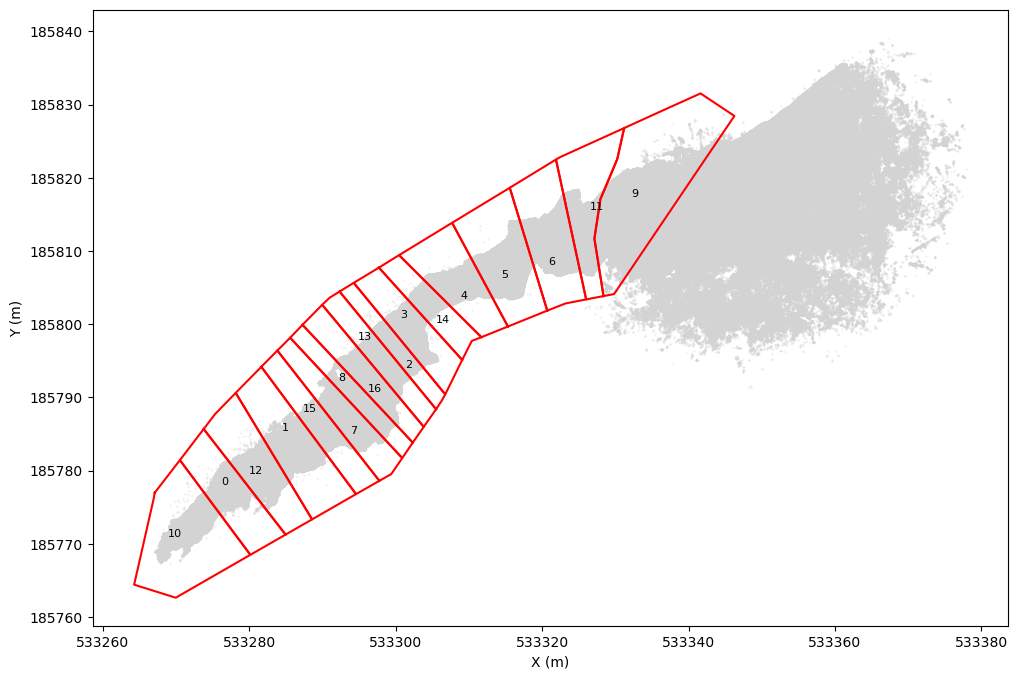

In [37]:
fig, ax = plt.subplots(figsize = (15, 8))

ax, res = plot_segmentation_scheme(root, ax, scan=scan)
plt.xlabel("X (m)")
plt.ylabel("Y (m)")
ax.set_aspect("equal")
plt.savefig(os.path.join(root, "output/SegmentationScheme.png"), dpi = 300)
plt.show()

In [40]:
if georef == False:
    
    CLOUD_FILEPATH = os.path.normpath(os.path.join(root, p["paths"]["inCloudName"][scan]))
else: 
    CLOUD_FILEPATH = os.path.normpath(os.path.join(root, p["paths"]["georefOutCloudName"][scan]))

print(CLOUD_FILEPATH)


cloud = cc.loadPointCloud("../../real_data/06_GrandFontannet/output/GrandFontannet_Cut2D.las",  cc.CC_SHIFT_MODE.XYZ, 0, *GLOBAL_SHIFT)

..\..\real_data\06_GrandFontannet\output\GrandFontannet_Cut2D.las


In [41]:
cc_polylines = res[0]
print(cloud.getOwnBB().maxCorner())

(48.507999420166016, 27.94700050354004, 13.27299976348877)


In [42]:
cc_polylines[0].getBoundingBox()

[(-29.513751983642578, -31.501564025878906, 1400.0),
 (-15.040071487426758, -14.306607246398926, 1400.0)]

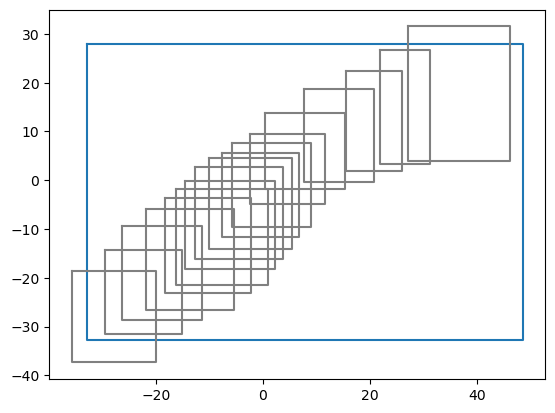

In [43]:
fig, ax = plt.subplots()

maxcorner = cloud.getOwnBB().maxCorner()
mincorner = cloud.getOwnBB().minCorner()
ax.plot([mincorner[0], maxcorner[0], maxcorner[0], mincorner[0], mincorner[0]], [maxcorner[1], maxcorner[1], mincorner[1], mincorner[1],maxcorner[1]])
for polyline in cc_polylines:
    mincorner, maxcorner = polyline.getBoundingBox()

    ax.plot([mincorner[0], maxcorner[0], maxcorner[0], mincorner[0], mincorner[0]], [maxcorner[1], maxcorner[1], mincorner[1], mincorner[1],maxcorner[1]], color = "grey")

In [44]:
# cycle through each polyline and cut the cloud, then save to a new ply file.  
for c, polyline in tqdm(enumerate(cc_polylines), total = len(cc_polylines)):
    if c>= 0:
        print(c, polyline.getBoundingBox())
        # crop the cloud using the polyline, only leave stuff inside. 
        CloudCropZ = cloud.crop2D(polyline, 2, True) # 2 means that the viewing direction is parallel to Z axis and cropping is done from top view accordingly. 
        print(f"../../real_data/{caveName}/process/cropped_clouds/{ScanName}_Cropped_{c}.ply")
        print(CloudCropZ.size())
        ret = cc.SavePointCloud(CloudCropZ, f"../../real_data/{caveName}/process/cropped_clouds/{ScanName}_Cropped_{c}.ply")

  6%|████▉                                                                              | 1/17 [00:37<09:59, 37.50s/it]

0 [(-29.513751983642578, -31.501564025878906, 1400.0), (-15.040071487426758, -14.306607246398926, 1400.0)]
../../real_data/06_GrandFontannet/process/cropped_clouds/GrandFontannet_Cropped_0.ply
45812993
1 [(-21.868576049804688, -26.654138565063477, 1400.0), (-5.416263103485107, -5.811211109161377, 1400.0)]
../../real_data/06_GrandFontannet/process/cropped_clouds/GrandFontannet_Cropped_1.ply
45368187


 12%|█████████▊                                                                         | 2/17 [01:14<09:14, 36.94s/it]

2 [(-7.690466403961182, -11.60584831237793, 1400.0), (6.725451946258545, 5.663553237915039, 1400.0)]
../../real_data/06_GrandFontannet/process/cropped_clouds/GrandFontannet_Cropped_2.ply
86137269


 18%|██████████████▋                                                                    | 3/17 [02:07<10:22, 44.49s/it]

3 [(-5.727146625518799, -9.578429222106934, 1400.0), (9.076518058776855, 7.728589057922363, 1400.0)]
../../real_data/06_GrandFontannet/process/cropped_clouds/GrandFontannet_Cropped_3.ply
138855282


 24%|███████████████████▌                                                               | 4/17 [03:13<11:28, 52.95s/it]

4 [(0.45752817392349243, -1.7646204233169556, 1400.0), (15.285401344299316, 13.856144905090332, 1400.0)]


 29%|████████████████████████▍                                                          | 5/17 [03:59<10:03, 50.33s/it]

../../real_data/06_GrandFontannet/process/cropped_clouds/GrandFontannet_Cropped_4.ply
76408690
5 [(7.708740711212158, -0.313192218542099, 1400.0), (20.715837478637695, 18.635498046875, 1400.0)]


 35%|█████████████████████████████▎                                                     | 6/17 [04:35<08:23, 45.76s/it]

../../real_data/06_GrandFontannet/process/cropped_clouds/GrandFontannet_Cropped_5.ply
47818034
6 [(15.546859741210938, 1.8589839935302734, 1400.0), (25.976806640625, 22.5013370513916, 1400.0)]


 41%|██████████████████████████████████▏                                                | 7/17 [05:11<07:04, 42.47s/it]

../../real_data/06_GrandFontannet/process/cropped_clouds/GrandFontannet_Cropped_6.ply
29555419
7 [(-16.180238723754883, -21.386493682861328, 1400.0), (0.8700529336929321, -1.8459311723709106, 1400.0)]


 47%|███████████████████████████████████████                                            | 8/17 [05:48<06:04, 40.55s/it]

../../real_data/06_GrandFontannet/process/cropped_clouds/GrandFontannet_Cropped_7.ply
32022619
8 [(-14.460389137268066, -18.28461456298828, 1400.0), (2.33380126953125, -0.08012636750936508, 1400.0)]


 53%|███████████████████████████████████████████▉                                       | 9/17 [06:19<05:02, 37.77s/it]

../../real_data/06_GrandFontannet/process/cropped_clouds/GrandFontannet_Cropped_8.ply
26319517
9 [(27.151931762695312, 3.845719575881958, 1400.0), (46.23268127441406, 31.530649185180664, 1400.0)]


 59%|████████████████████████████████████████████████▏                                 | 10/17 [07:14<05:01, 43.09s/it]

../../real_data/06_GrandFontannet/process/cropped_clouds/GrandFontannet_Cropped_9.ply
43430626
10 [(-35.72489547729492, -37.36494064331055, 1400.0), (-19.873777389526367, -18.567935943603516, 1400.0)]


 65%|█████████████████████████████████████████████████████                             | 11/17 [07:58<04:20, 43.41s/it]

../../real_data/06_GrandFontannet/process/cropped_clouds/GrandFontannet_Cropped_10.ply
31437255
11 [(21.88680076599121, 3.382936716079712, 1400.0), (31.176795959472656, 26.79522132873535, 1400.0)]
../../real_data/06_GrandFontannet/process/cropped_clouds/GrandFontannet_Cropped_11.ply
24273910


 71%|█████████████████████████████████████████████████████████▉                        | 12/17 [08:48<03:45, 45.19s/it]

12 [(-26.267026901245117, -28.72743797302246, 1400.0), (-11.427504539489746, -9.375557899475098, 1400.0)]
../../real_data/06_GrandFontannet/process/cropped_clouds/GrandFontannet_Cropped_12.ply
57863827


 76%|██████████████████████████████████████████████████████████████▋                   | 13/17 [09:32<02:59, 44.79s/it]

13 [(-10.038274765014648, -14.009419441223145, 1400.0), (5.493812561035156, 4.466414928436279, 1400.0)]
../../real_data/06_GrandFontannet/process/cropped_clouds/GrandFontannet_Cropped_13.ply
85381902


 82%|███████████████████████████████████████████████████████████████████▌              | 14/17 [10:25<02:22, 47.48s/it]

14 [(-2.3404722213745117, -4.876296520233154, 1400.0), (11.656824111938477, 9.43467903137207, 1400.0)]
../../real_data/06_GrandFontannet/process/cropped_clouds/GrandFontannet_Cropped_14.ply
58269942


 88%|████████████████████████████████████████████████████████████████████████▎         | 15/17 [11:10<01:33, 46.59s/it]

15 [(-18.361711502075195, -23.20419692993164, 1400.0), (-2.249073028564453, -3.5939741134643555, 1400.0)]
../../real_data/06_GrandFontannet/process/cropped_clouds/GrandFontannet_Cropped_15.ply
19654576


 94%|█████████████████████████████████████████████████████████████████████████████▏    | 16/17 [11:40<00:41, 41.54s/it]

16 [(-12.723069190979004, -16.170310974121094, 1400.0), (3.8298044204711914, 2.6486880779266357, 1400.0)]
../../real_data/06_GrandFontannet/process/cropped_clouds/GrandFontannet_Cropped_16.ply
34402619


100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [12:13<00:00, 43.14s/it]
